# NTF and Robust-NTF on Corrupted Synthetic Data

Here, we generate a synthetic low-rank 3-dimensional tensor from known signals. We insert nonlinear outliers (1% and 19% of the overall dataset) and observe the performance of classic non-negative tensor factorization against the proposed robust variant.

## Setup

In [1]:
import torch
import numpy as np
import tensorly as tl
import matplotlib.pyplot as plt
import sys
from torch.nn.functional import normalize
from scipy import signal
from scipy.stats import gamma
from tensorly.kruskal_tensor import kruskal_to_tensor
from tensorly.decomposition.candecomp_parafac import non_negative_parafac
from tensorly.tenalg.outer_product import outer

sys.path.append("..")
from robust_ntf.robust_ntf import robust_ntf

# Use the GPU at fp64 by default:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

# Make TensorLy use PyTorch:
tl.set_backend('pytorch')

# Set RNG seeds:
torch.manual_seed(33)
np.random.seed(33)

# Set an epsilon to protect against zeros:
eps = 1e-6

## Part 1: Generate synthetic tensor

### Generate ground truth factors:

Over here, we generate ground truth factor matrices to generate a rank-3 synthetic tensor with. They include,

* A Gaussian modulated sinusoid and take its real and imaginary parts, and its envelope to be the ground truth factors.
* Three different chirp signals.
* Three different Gamma PDFs.

In [2]:
#######################
## Mode-1 generation ##
#######################

# Sample 50 points:
mode1_support = np.linspace(-1, 1, 2*25, endpoint=False)

# Generate signal and plot:
x1, x2, x3 = signal.gausspulse(mode1_support, fc=5,
                               retquad=True, retenv=True)

#######################
## Mode-2 generation ##
#######################

mode2_support = np.linspace(-1, 1, 96, endpoint=False)
y1 = signal.chirp(mode2_support, f0=4, t1=-0.5, f1=4)
y2 = signal.chirp(mode2_support, f0=2, t1=0.5, f1=3)
y3 = signal.chirp(mode2_support, f0=1, t1=0.1, f1=2)

#######################
## Mode-3 generation ##
#######################

mode3_support = np.linspace(0, 10, 20)

z1 = gamma(7).pdf(mode3_support)
z2 = gamma(2).pdf(mode3_support)
z3 = gamma(4).pdf(mode3_support)

### Plot ground truth factors:

Text(0.5, 1.0, 'Mode-3 factors')

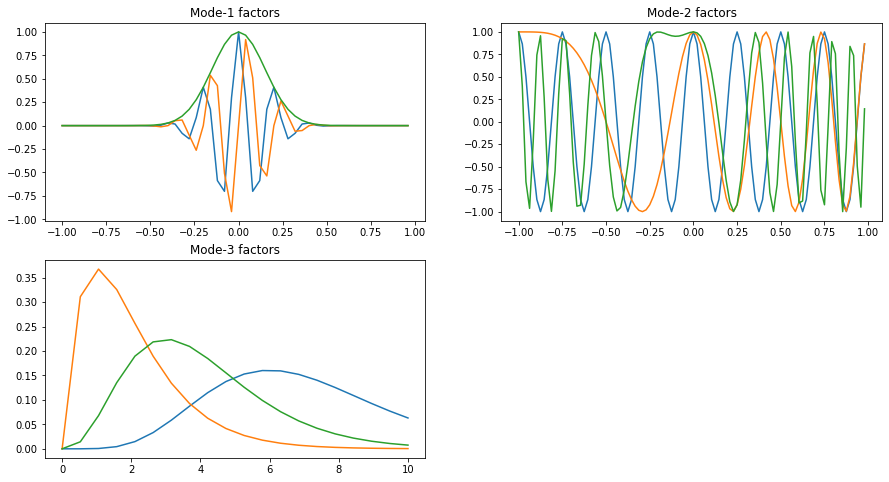

In [3]:
# Set up figure size:
fig = plt.figure(figsize=(15,8))

# Plot factors:
plt.subplot(2,2,1)
plt.plot(mode1_support, x1,
         mode1_support, x2,
         mode1_support, x3)
plt.gca().set_title('Mode-1 factors')

plt.subplot(2,2,2)
plt.plot(mode2_support, y1,
         mode2_support, y2,
         mode2_support, y3)
plt.gca().set_title('Mode-2 factors')

plt.subplot(2,2,3)
plt.plot(mode3_support, z1,
         mode3_support, z2,
         mode3_support, z3)
plt.gca().set_title('Mode-3 factors')


### Cast factors to PyTorch and/or make positive:

In [4]:
# Mode-1:
X = np.array([x1, x2, x3])
X = torch.from_numpy(X).cuda()
X = X - X.min() + eps

# Mode-2:
Y = np.array([y1, y2, y3])
Y = torch.from_numpy(Y).cuda()
Y = Y - Y.min() + eps

# Mode-3:
Z = np.array([z1, z2, z3])
Z = torch.from_numpy(Z).cuda() + eps

### Construct ground truth tensor to factorize:

In [5]:
# Construct Kruskal tensor in TensorLy format:
ktens = (None, [X.t(), Y.t(), Z.t()])

# Construct dense tensor:
data = kruskal_to_tensor(ktens)

### Visualize some frontal slices of the tensor in false color:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


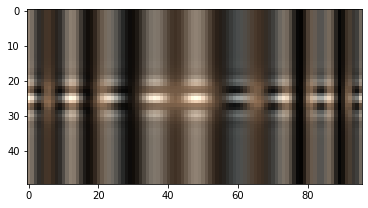

In [6]:
plt.imshow(data[:, :, 10:13].data.cpu().numpy())

### Add ~1% outliers to data:
We use the sigmoid function as an off-the-shelf nonlinearity, applied to individual **fibers** within the tensor. 

In [7]:
data_01 = data.clone()

m1_mask_01 = np.random.randint(0, 50, 5)
m2_mask_01 = np.random.randint(0, 96, 10)
m3_mask_01 = np.random.randint(0, 20, 5)

for i in m1_mask_01:
    for j in m2_mask_01:
        data_01[i, j, :] = torch.sigmoid(data[i, j, :])

for j in m2_mask_01:
    for k in m3_mask_01:
        data_01[:, j, k] = torch.sigmoid(data[:, j, k])

for i in m1_mask_01:
    for k in m3_mask_01:
        data_01[i, :, k] = torch.sigmoid(data[i, :, k])

### Add ~19% outliers to data:
We use the sigmoid function as an off-the-shelf nonlinearity, applied to individual **slices** within the tensor. 

In [8]:
data_19 = data.clone()

m1_mask_19 = np.random.randint(0, 50, 2)
m2_mask_19 = np.random.randint(0, 96, 5)
m3_mask_19 = np.random.randint(0, 20, 2)

data_19[m1_mask_19, :, :] = torch.sigmoid(data[m1_mask_19, :, :])
data_19[:, m2_mask_19, :] = torch.sigmoid(data[:, m2_mask_19, :])
data_19[:, :, m3_mask_19] = torch.sigmoid(data[:, :, m3_mask_19])

## Part 2: Compare methods

### Perform NTF and rNTF on synthetic data with 1% outliers:

In [9]:
# Perform NTF:
ntf_01 = non_negative_parafac(data_01, 3, n_iter_max=20000, tol=1e-7, verbose=0)

# Perform robust-NTF:
rntf_01_factors, rntf_01_outlier, _ = robust_ntf(data_01, 3, 2, 0.1, 1e-7, max_iter=20000, print_every=100)

Initializing rNTF with uniform noise.
Iter = 0; Obj = 27667.789215736644
Iter = 1; Obj = 351.26762506518065; Err = 0.98730409494137
Iter = 101; Obj = 95.6761178300026; Err = 0.012051374727485043
Iter = 201; Obj = 38.294557713684895; Err = 0.0010896849887672808
Iter = 301; Obj = 37.05861165093481; Err = 9.414522494507675e-05
Iter = 401; Obj = 36.82050227445185; Err = 3.203444485526347e-05
Iter = 501; Obj = 36.75101558656672; Err = 1.097318292198068e-05
Iter = 601; Obj = 36.724984606734466; Err = 4.3232201649542625e-06
Iter = 701; Obj = 36.7138412121526; Err = 2.3362283548361858e-06
Iter = 801; Obj = 36.70357209792816; Err = 2.7860076718062916e-06
Algorithm converged as per defined tolerance


### Plot results for 1% outliers:
Here, mode-3 factors for NTF and rNTF are plotted. With 1% outliers, NTF components are degraded, whereas rNTF is relatively stable.

Similar results are observed for mode-1 and mode-2.

Text(0.5, 1.0, 'robust-NTF Mode-3 results')

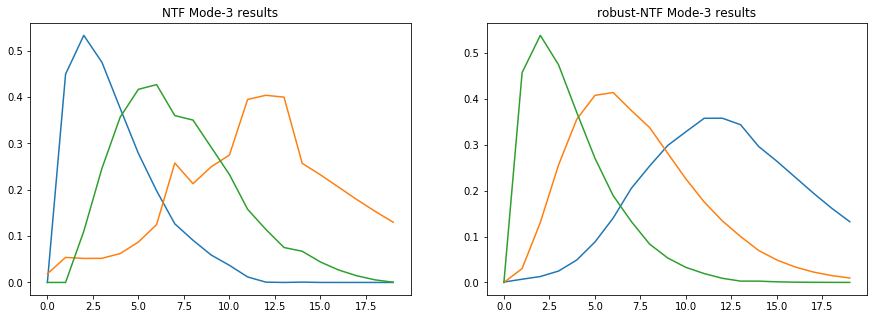

In [10]:
# Set up figure size:
fig = plt.figure(figsize=(15,5))

# Plot mode-3 factors:
plt.subplot(1,2,1)
plt.plot(normalize(ntf_01[1][2], dim=0).data.cpu().numpy())
plt.gca().set_title('NTF Mode-3 results')

plt.subplot(1,2,2)
plt.plot(normalize(rntf_01_factors[2], dim=0).data.cpu().numpy())
plt.gca().set_title('robust-NTF Mode-3 results')

### Perform NTF and rNTF on synthetic data with 19% outliers:

In [11]:
# Perform NTF:
ntf_19 = non_negative_parafac(data_19, 3, n_iter_max=20000, tol=1e-7, verbose=0)

# Perform robust-NTF:
rntf_19_factors, rntf_19_outlier, _ = robust_ntf(data_19, 3, 2, 0.05, 1e-7, max_iter=20000, print_every=100)

Initializing rNTF with uniform noise.
Iter = 0; Obj = 28299.62488695398
Iter = 1; Obj = 232.1045751801073; Err = 0.9917983161929788
Iter = 101; Obj = 113.30852494449748; Err = 0.0025238560478414215
Iter = 201; Obj = 92.86407986354384; Err = 0.0016730314377399972
Iter = 301; Obj = 78.69867447004611; Err = 0.0014969775740551823
Iter = 401; Obj = 71.22687342574308; Err = 0.0006529600314466549
Iter = 501; Obj = 67.18207566901278; Err = 0.0006125529394865001
Iter = 601; Obj = 63.610987041115905; Err = 0.0004807299572490733
Iter = 701; Obj = 61.35598635692729; Err = 0.00026858973362525116
Iter = 801; Obj = 60.14728126343141; Err = 0.000130421310326921
Iter = 901; Obj = 59.630277582817016; Err = 5.277597575071794e-05
Iter = 1001; Obj = 59.40207115229093; Err = 2.6722197341437844e-05
Iter = 1101; Obj = 59.27145040084755; Err = 1.9261252139130105e-05
Iter = 1201; Obj = 59.172687368834616; Err = 1.5357557510795676e-05
Iter = 1301; Obj = 59.07872531929985; Err = 1.3095252415049619e-05
Iter = 1401

### Plot results for 19% outliers:
Here, mode-3 factors for NTF and rNTF are plotted. With 19% outliers, both methods suffer - but rNTF shows more robustness to them. It is possible that better tuning of regularization weight will improve results.

Similar results are observed for mode-1 and mode-2.

Text(0.5, 1.0, 'robust-NTF Mode-3 results')

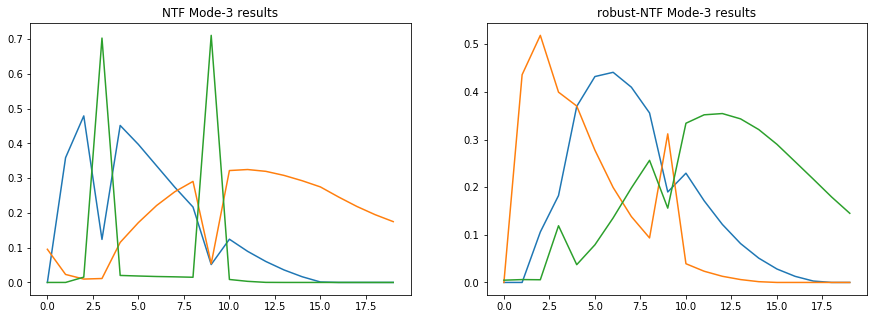

In [12]:
# Set up figure size:
fig = plt.figure(figsize=(15, 5))

# Plot mode-3 factors:
plt.subplot(1,2,1)
plt.plot(normalize(ntf_19[1][2], dim=0).data.cpu().numpy())
plt.gca().set_title('NTF Mode-3 results')

plt.subplot(1,2,2)
plt.plot(normalize(rntf_19_factors[2], dim=0).data.cpu().numpy())
plt.gca().set_title('robust-NTF Mode-3 results')

## Visualize reconstructions: Data, NTF, and rNTF

rNTF is visually closer to the original dataset than NTF, but has noticeable artefacts.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Robust-NTF reconstruction slices')

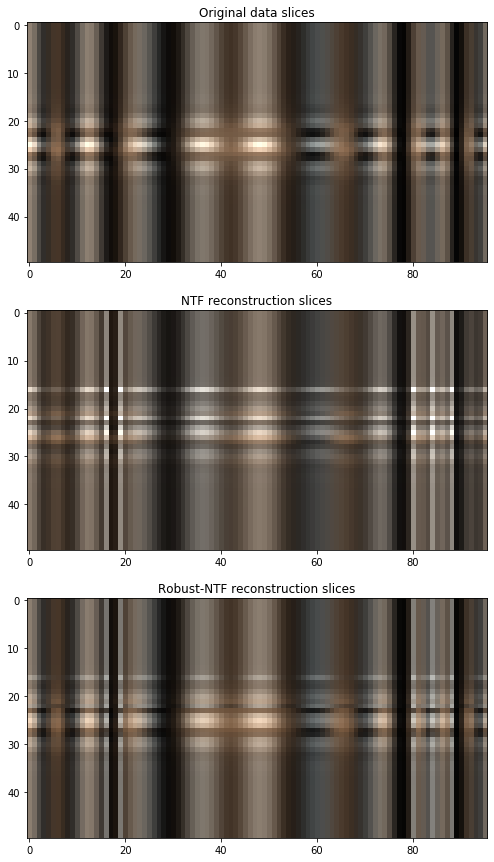

In [13]:
# Reconstruct NTF factors:
ntf_recon = kruskal_to_tensor(ntf_19)

# Reconstruct rNTF factors:
rntf_recon = torch.zeros(50,96,20)

for i in range(3):
    rntf_recon = rntf_recon + outer([rntf_19_factors[0][:,i],
                                     rntf_19_factors[1][:,i],
                                     rntf_19_factors[2][:,i]])

## Plot results:
# Set up figure size:
fig = plt.figure(figsize=(10, 15))

# Plot original data:
plt.subplot(3,1,1)
plt.imshow(data[:, :, 10:13].data.cpu().numpy())
plt.gca().set_title('Original data slices')

# Plot NTF reconstruction:
plt.subplot(3,1,2)
plt.imshow(ntf_recon[:, :, 10:13].data.cpu().numpy())
plt.gca().set_title('NTF reconstruction slices')

# Plot rNTF reconstruction:
plt.subplot(3,1,3)
plt.imshow(rntf_recon[:, :, 10:13].data.cpu().numpy())
plt.gca().set_title('Robust-NTF reconstruction slices')